<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/RNN_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/kospi_sen_all.csv')
stock_data

,Date,research_kospi,Kospi_open,Kospi_high,Kospi_low,Kospi_close,Kospi_vol,dji_open,dji_high,dji_low,...,oil_low,oil_close,oil_vol,ko_interest,ko_consumer,ko_real_estate,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,klue_bert_score_summarize_content,klue_bert_score_title
0,20210104,0.385,0.765,0.795,0.770,2944.45,0.232,0.656,0.648,0.633,...,0.209,0.199,0.006,0.0,0.137,0.911,-0.749,0.083,0.742,0.785
1,20210105,0.413,0.802,0.819,0.799,2990.57,0.388,0.632,0.638,0.647,...,0.225,0.220,0.013,0.0,0.137,0.911,0.157,0.195,-0.536,0.823
2,20210106,0.628,0.830,0.839,0.820,2968.21,0.474,0.641,0.667,0.657,...,0.230,0.222,0.006,0.0,0.137,0.911,1.236,0.569,1.381,0.722
3,20210107,0.427,0.823,0.855,0.830,3031.68,0.389,0.671,0.677,0.689,...,0.236,0.228,0.007,0.0,0.137,0.911,0.537,1.395,1.845,-0.675
4,20210108,0.512,0.855,0.914,0.862,3152.18,0.318,0.681,0.674,0.683,...,0.242,0.239,0.004,0.0,0.137,0.911,0.697,-1.382,2.497,1.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,20230623,0.125,0.614,0.602,0.608,2570.10,0.074,0.837,0.825,0.838,...,0.667,0.652,0.000,1.0,0.999,0.289,0.834,-0.339,0.402,0.831
585,20230626,0.120,0.598,0.594,0.605,2582.20,0.059,0.831,0.824,0.836,...,0.667,0.652,0.000,1.0,0.999,0.289,-0.196,0.681,-0.385,-0.001
586,20230627,0.118,0.604,0.592,0.608,2581.39,0.076,0.831,0.833,0.842,...,0.667,0.652,0.000,1.0,0.999,0.289,-0.208,0.625,-0.447,-0.097
587,20230628,0.128,0.610,0.597,0.603,2564.19,0.060,0.839,0.829,0.844,...,0.667,0.652,0.000,1.0,0.999,0.289,1.099,0.892,0.777,0.253


In [3]:
stock_data = stock_data.dropna()

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     589 non-null    int64  
 1   research_kospi                           589 non-null    float64
 2   Kospi_open                               589 non-null    float64
 3   Kospi_high                               589 non-null    float64
 4   Kospi_low                                589 non-null    float64
 5   Kospi_close                              589 non-null    float64
 6   Kospi_vol                                589 non-null    float64
 7   dji_open                                 589 non-null    float64
 8   dji_high                                 589 non-null    float64
 9   dji_low                                  589 non-null    float64
 10  dji_close                                589 non-n

In [5]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)

In [6]:
name = [stock_data.columns]

close = ['kofinbert_score_summarize_content_kospi',
        'kofinbert_score_title_kospi',
        'klue_bert_score_title']

stock_data = stock_data.drop(close, axis=1)

In [7]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t, test_data_t = stock_data[:train_size], stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t, train_data, look_back)
testX, testY = create_dataset(test_data_t,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(495, 5, 37)
(495, 1)
(84, 5, 37)
(84, 1)


In [8]:
earlystopping = EarlyStopping(monitor='val_loss', patience=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 1024)           3265536   
                                                                 
 dropout (Dropout)           (None, 5, 1024)           0         
                                                                 
 gru_1 (GRU)                 (None, 5, 512)            2362368   
                                                                 
 dropout_1 (Dropout)         (None, 5, 512)            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 256)            591360    
                                                                 
 dropout_2 (Dropout)         (None, 5, 256)            0         
                                                                 
 gru_3 (GRU)                 (None, 5, 128)            1

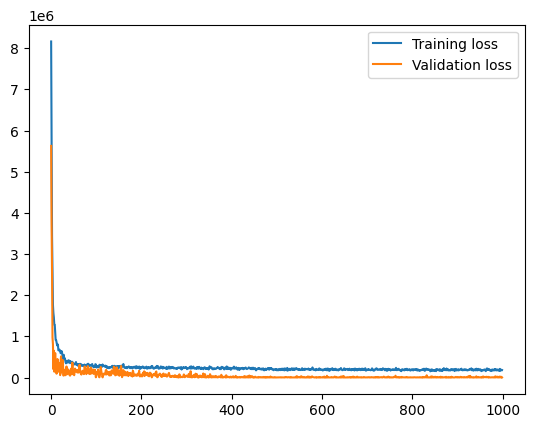

3/3 [==============================] - 0s 69ms/step


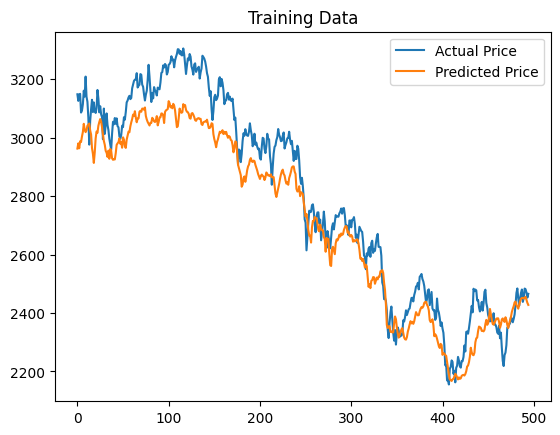

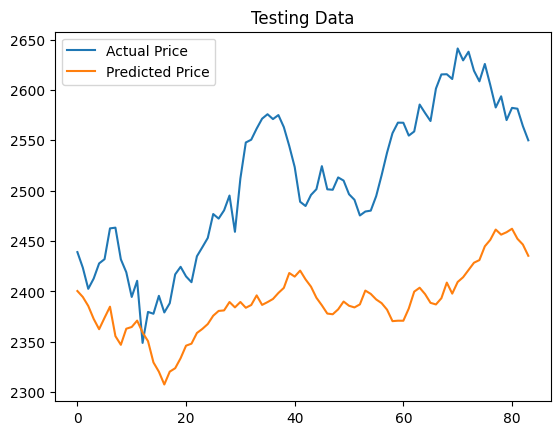

In [9]:
# 모델 생성
model = Sequential()
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2, callbacks=[checkpoint])

model.save_weights('./lstm_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 128)            14336     
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 128)            0         
 D)                                                              
                                                                 
 gru_6 (GRU)                 (None, 1, 1024)           3545088   
                                                                 
 dropout_6 (Dropout)         (None, 1, 1024)           0         
                                                                 
 gru_7 (GRU)                 (None, 1, 512)            2362368   
                                                                 
 dropout_7 (Dropout)         (None, 1, 512)            0         
                                                      

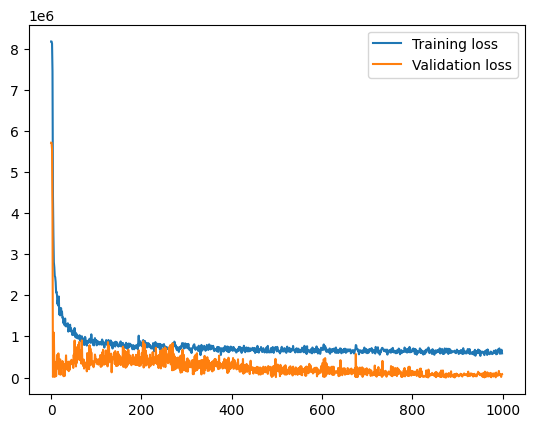

3/3 [==============================] - 0s 19ms/step


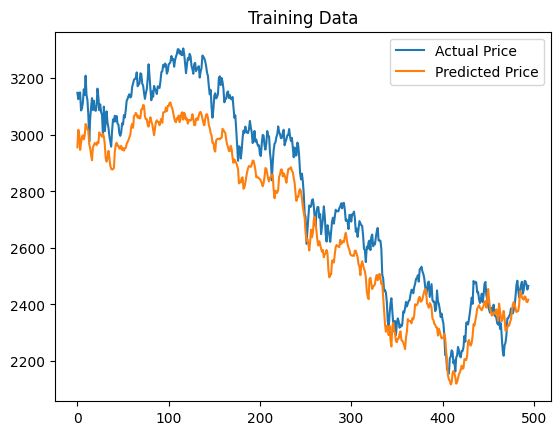

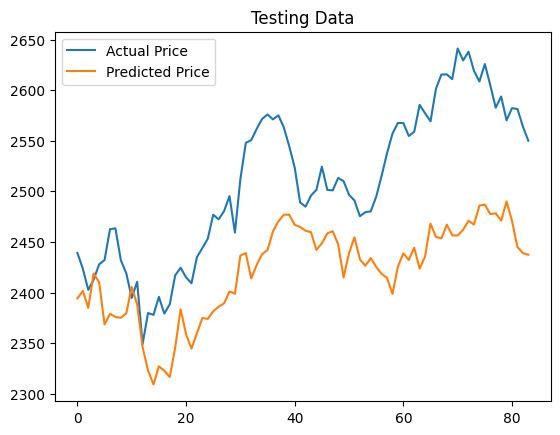

In [10]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 128)            14336     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 1, 1024)           4722688   
                                                                 
 dropout_13 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            3147776   
                                                                 
 dropout_14 (Dropout)        (None, 1, 512)            0         
                                                      

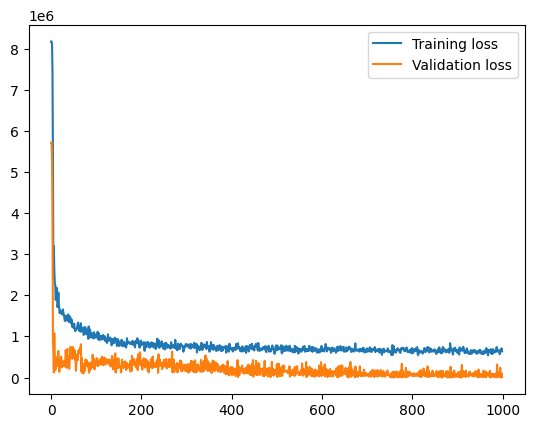

3/3 [==============================] - 0s 22ms/step


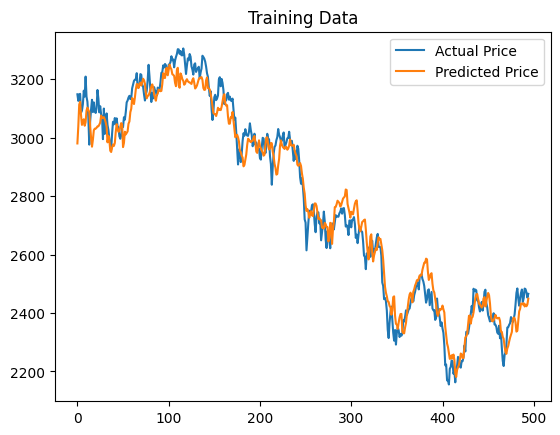

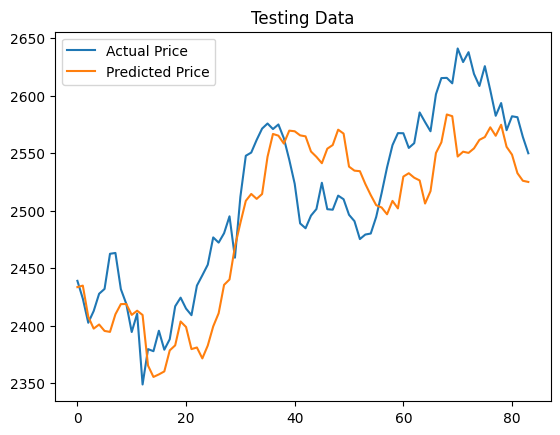

In [11]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 1024)           4349952   
                                                                 
 dropout_20 (Dropout)        (None, 5, 1024)           0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 512)            3147776   
                                                                 
 dropout_21 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 256)            787456    
                                                                 
 dropout_22 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 128)           

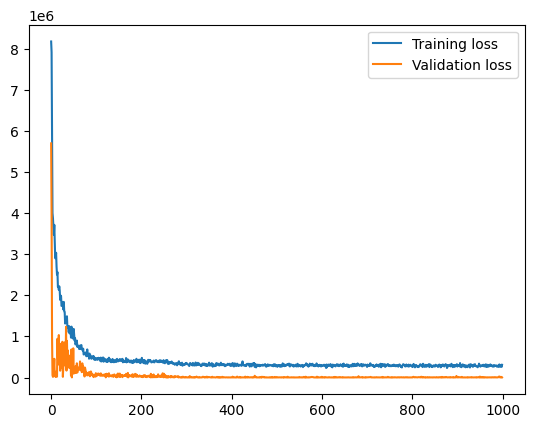

3/3 [==============================] - 0s 135ms/step


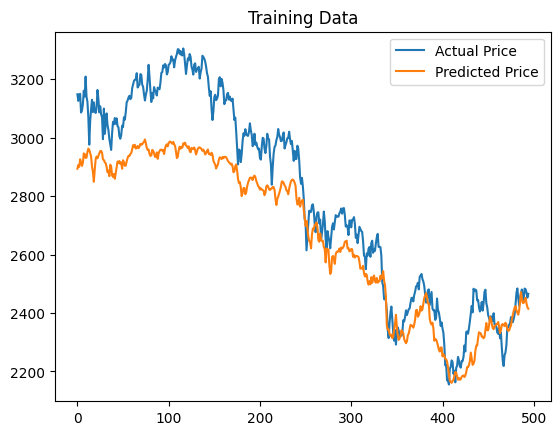

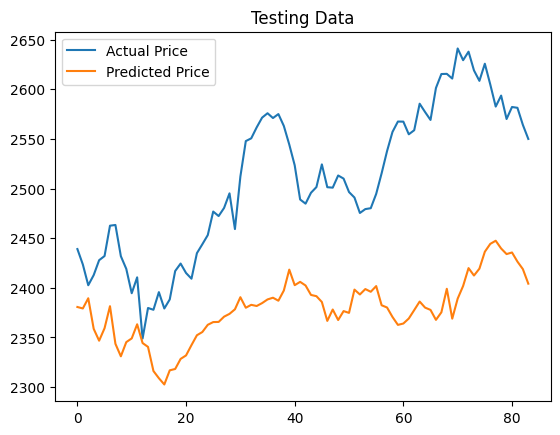

In [12]:
# 모델 생성
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [13]:
trainX.shape

(495, 5, 37)

In [14]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

ValueError: ignored

In [ ]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()